In [1]:
import os
os.chdir('..')
import warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import numpy as np # type: ignore


In [3]:
price_data=pd.read_csv('docs/BrentOilPrices.csv')


### Read loaded dataset

In [4]:
price_data.head()


,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


### Find the information of the dataset

In [5]:
price_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


### Check missing value

In [6]:
price_data.isnull().sum()


Date     0
Price    0
dtype: int64

In [7]:
price_data['Date'] = pd.to_datetime(price_data['Date'])


In [8]:
price_data.head()


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [9]:
price_data['year']=price_data['Date'].dt.year


In [10]:
price_data['year']


0       1987
1       1987
2       1987
3       1987
4       1987
        ... 
9006    2022
9007    2022
9008    2022
9009    2022
9010    2022
Name: year, Length: 9011, dtype: int32

In [9]:
price_data.set_index('Date',inplace=True)


In [10]:
price_data.head()


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


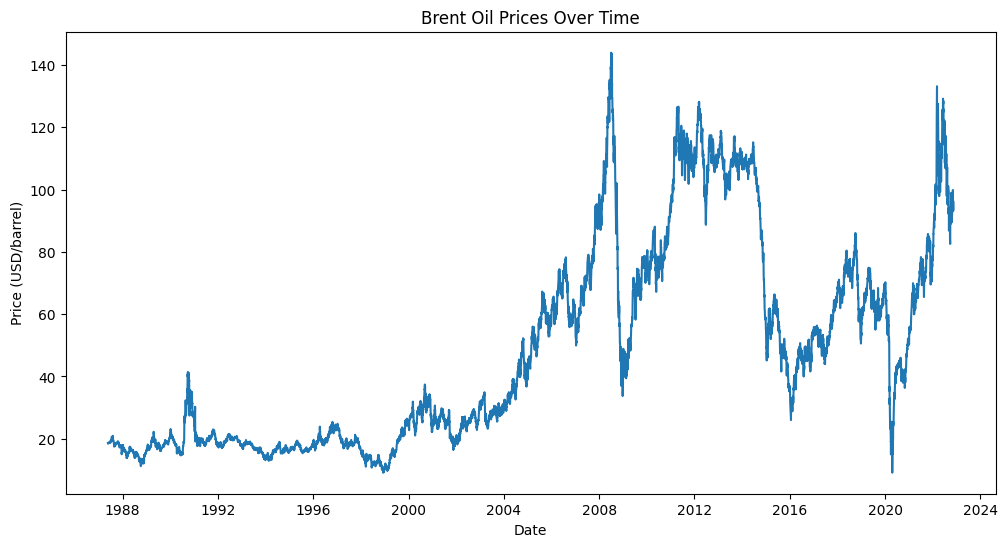

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(price_data['Price'])
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD/barrel)")
plt.show()


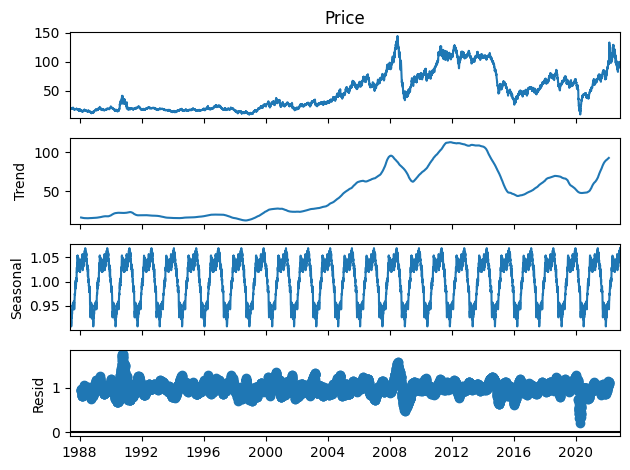

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose  # type: ignore

# Decompose the time series
decomposition = seasonal_decompose(price_data['Price'], model='multiplicative', period=365)

decomposition.plot()
plt.show()


In [13]:
import pymc as pm
import numpy as np

# Prepare data for PyMC3
prices = price_data['Price'].values
n = len(prices)

# Define model
with pm.Model() as model:
    # Prior on the change point
    change_point = pm.DiscreteUniform("change_point", lower=0, upper=n)

    # Priors for mean and standard deviation before and after the change point
    mean1 = pm.Normal("mean1", mu=np.mean(prices[:n//2]), sigma=np.std(prices[:n//2]))
    mean2 = pm.Normal("mean2", mu=np.mean(prices[n//2:]), sigma=np.std(prices[n//2:]))
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Likelihood
    idx = np.arange(n)
    mean = pm.math.switch(idx < change_point, mean1, mean2)
    obs = pm.Normal("obs", mu=mean, sigma=sigma, observed=prices)

    # Sample from posterior
    trace = pm.sample(1000, tune=1000, target_accept=0.9)

# Plot results


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [change_point]
>NUTS: [mean1, mean2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


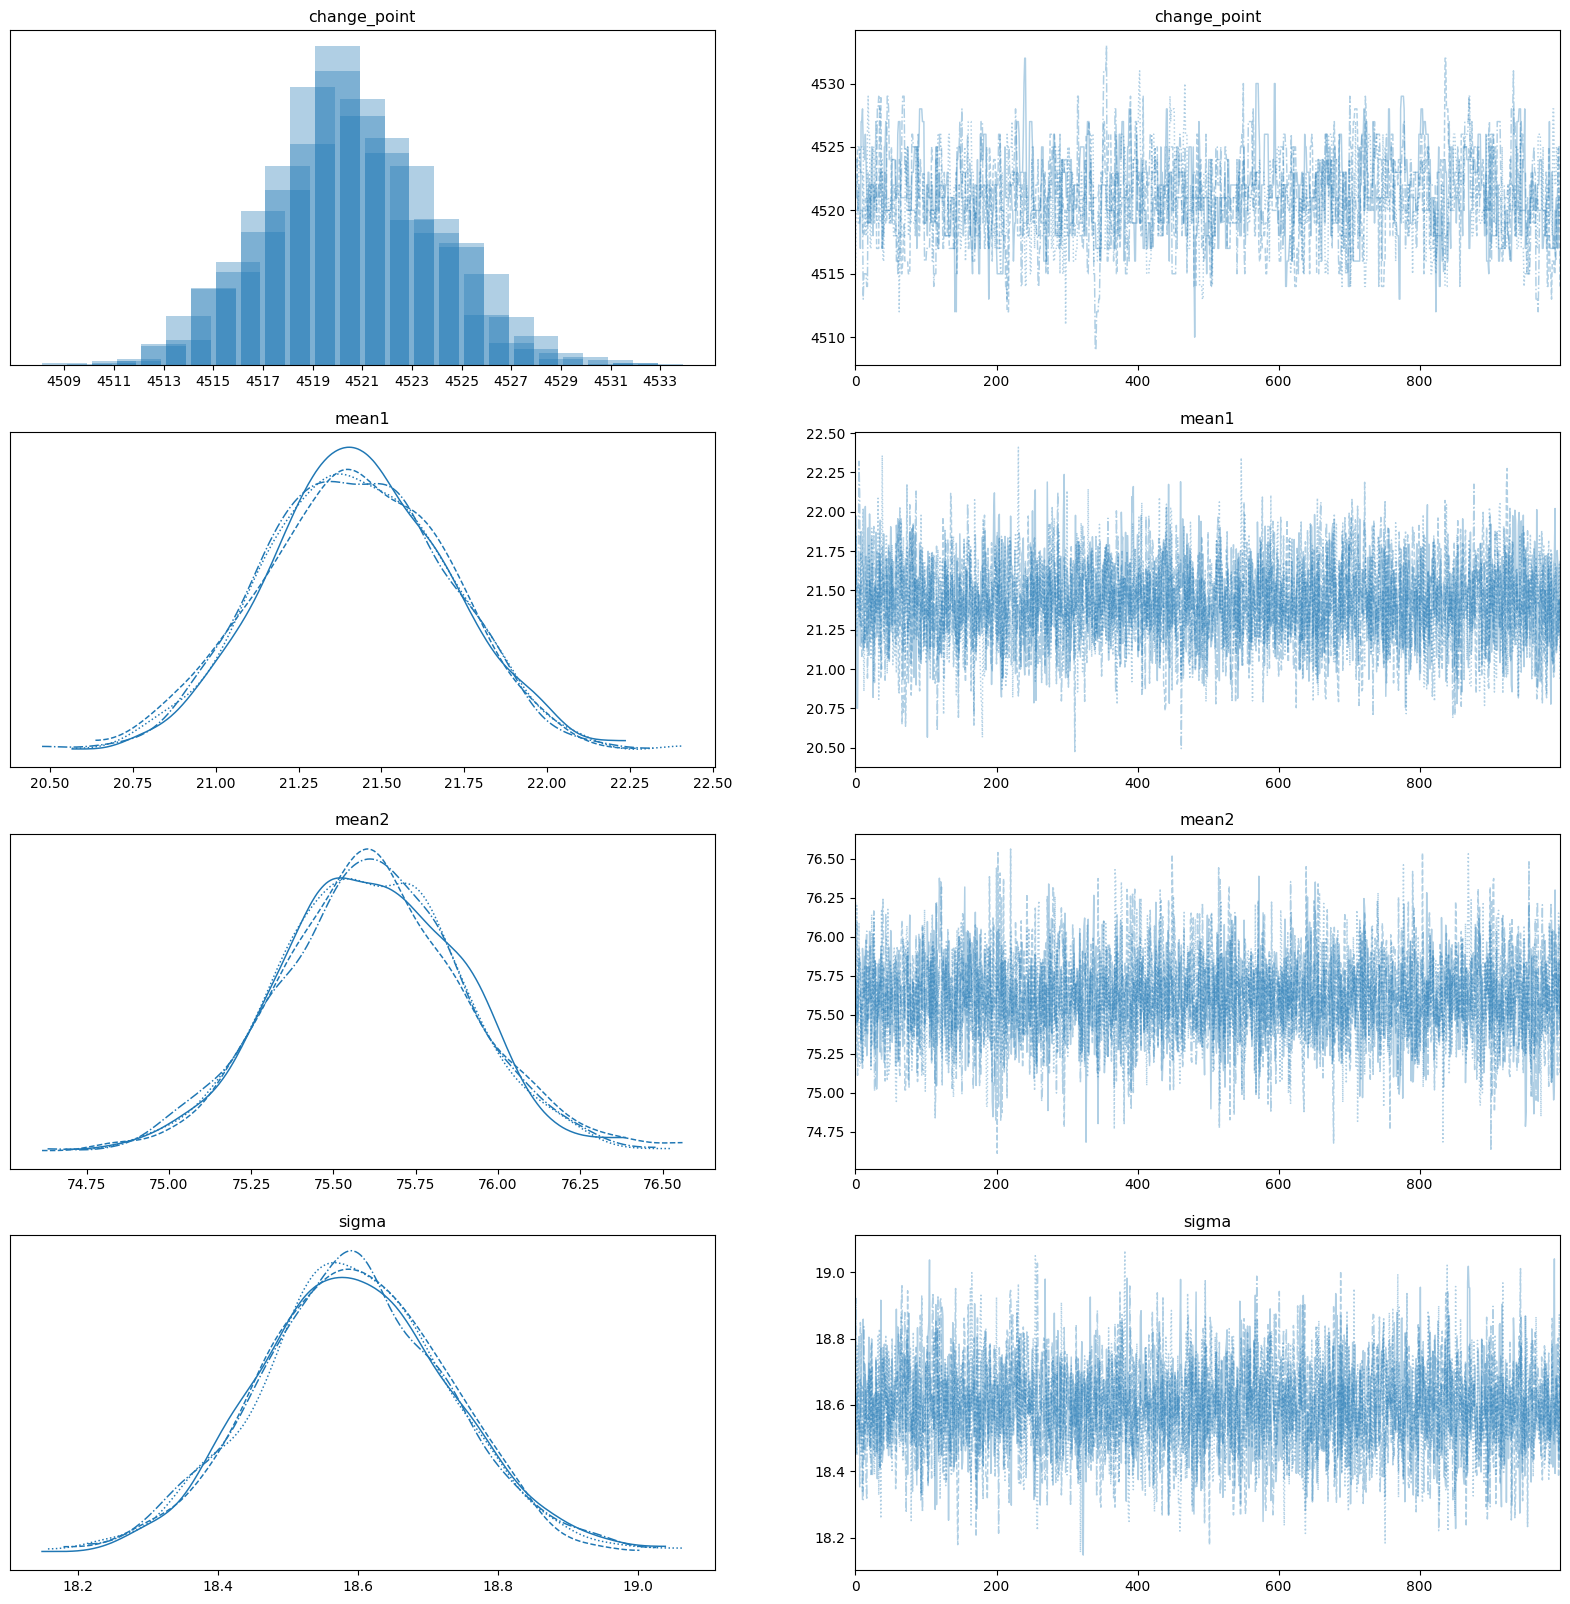

In [14]:
pm.plot_trace(trace,figsize=(20,20))
plt.show()
